In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Base directory: where the SeismicDesignModule package is stored
base_directory = 'C:\\Users\\XINGQUAN GUAN\\Documents\\GitHub\\SeismicDesignModule'

# Postprocessing folder path
postprocessing_directory = base_directory + '\\Poseprocessing'

# Preprocessing folder path
preprocessing_directory = base_directory + '\\Preprocessing'

# Design results folder path
design_directory = base_directory + '\\BuildingData'

# Load the section database
os.chdir(base_directory)
with open('AllSectionDatabase.csv', 'r') as file:
    SECTION_DATABASE = pd.read_csv(file, header=0)

# Load the design sampling space
os.chdir(preprocessing_directory)
with open('DesignSheet2.csv', 'r') as file:
    DESIGN_SPACE = pd.read_csv(file, header=0)


def extract_member_results(target_IDs, file_name, ratio):
    """
    :param target_IDs: a list which includes ID for buildings that we are interested.
    :param file_name: a string denoting the files that you want to read.
                      options: 'OptimalMemberSize.csv' or 'ConstructionSize.csv',
    :return members: a dictionary which includes three lists.
                     Each list has X element, where X is the number of total buildings that we are interested.
                     Each element is further a list with Y elements, where Y is the number of stories for each building.
    :ratio: 0.6, 0.8, or 1.0
    """
    # Initialize three lists to store member sizes for a bunch of buildings
    beam = []
    exterior_column = []
    interior_column = []
    for ID in target_IDs:
        # Open the folder and read the target files
        if ratio == 0.6:
            target_path = design_directory + "\\SensitivityBuilding_" + str(ID)
        elif ratio == 0.8:
            target_path = design_directory + '\\SensitivityBuilding_' + str(ID) + '_ExtIntCol08'
        else:
            target_path = design_directory + '\\SensitivityBuilding_' + str(ID) + '_ExtIntCol10'
        os.chdir(target_path)
        with open(file_name, 'r') as file:
            MemberSize = pd.read_csv(file, header=0)
        StoryNumber = MemberSize.shape[0]
        # Initialize three lists to store the member sizes for different stories in each building
        beam_per_building = []
        exterior_column_per_building = []
        interior_column_per_building = []
        # Loop all stories to read the sizes
        for story in range(0, StoryNumber):
            beam_per_building.append(MemberSize.loc[story, 'beam'])
            exterior_column_per_building.append(MemberSize.loc[story, 'exterior column'])
            interior_column_per_building.append(MemberSize.loc[story, 'interior column'])
        beam.append(beam_per_building)
        exterior_column.append(exterior_column_per_building)
        interior_column.append(interior_column_per_building)
    # Store all results into the dictionary
    members = {'beam': beam, 'exterior column': exterior_column, 'interior column': interior_column}
    return members


def extract_story_drift(target_IDs, file_name, ratio):
    """
    This function is used to extract the story drifts from building design results.
    :param: target_IDs: :param target_IDs: a list which includes ID for buildings that we are interested.
    :param file_name: a string denoting the files that you want to read.
                      options: 'OptimalDrift.csv', 'ConstructionDrift.csv'
    :param ratio: 0.6, 0.8, 1.0
    :return: a list with X elements, where X is the number of buildings that we are interested.
             each element is further a list with Y elements. Y is the number of stories for each building.
    """
    # Initialize a list to store the function output
    story_drift = []
    for ID in target_IDs:
        drift_per_building = []
        if ratio == 0.6:
            target_path = design_directory + '\\SensitivityBuilding_' + str(ID)
        elif ratio == 0.8:
            target_path = design_directory + '\\SensitivityBuilding_' + str(ID) + '_ExtIntCol08'
        else:
            target_path = design_directory + '\\SensitivityBuilding_' + str(ID) + '_ExtIntCol10'
        os.chdir(target_path)
        with open(file_name, 'r') as file1:
            StoryDrift = pd.read_csv(file1, header=0)
        RowNumber = StoryDrift.shape[0]
        for story in range(RowNumber):
            drift_per_building.append(StoryDrift.loc[story, 'story drift']*5.5*1.04*100)
        story_drift.append(drift_per_building)
    return story_drift


def extract_SCWB_ratio(target_IDs, file_name, ratio):
    """
    This function extract the strong column weak beam ratio from design results.
    :param: target_IDs: :param target_IDs: a list which includes ID for buildings that we are interested.
    :param file_name: a string denoting the files that you want to read.
                      options: 'OptimalColumnBeamRatio.csv', 'ConstructionColumnBeamRatio.csv'
    :param ratio: 0.6, 0.8, or 1.0
    :return column_beam_ratio: a dictionary which includes two lists for average interior joint and exterior joint.
                               Each list has X elements, where X is the number of buildings.
                               Each element is further a list with Y elements, where Y is the number of stories.
    """
    # Initialize two lists to store the ratios for interior and exterior joints respectively
    exterior_joint_ratio = []
    interior_joint_ratio = []
    for ID in target_IDs:
        # Initialize two lists to store the ratios for each story in a certain building
        interior_per_building = []
        exterior_per_building = []
        if ratio == 0.6:
            target_path = design_directory + '\\SensitivityBuilding_' + str(ID)
        elif ratio == 0.8:
            target_path = design_directory + '\\SensitivityBuilding_' + str(ID) + '_ExtIntCol08'
        else:
            target_path = design_directory + '\\SensitivityBuilding_' + str(ID) + '_ExtIntCol10'
        os.chdir(target_path)
        with open(file_name, 'r') as file1:
            SCWBRatio = pd.read_csv(file1, header=0)
        RowNumber = SCWBRatio.shape[0]
        for story in range(RowNumber):
            if not np.isnan(SCWBRatio.iloc[story, 0]):
                exterior_per_building.append(SCWBRatio.iloc[story, 0])
                interior_per_building.append(np.mean(SCWBRatio.iloc[story, 1:3]))
            else:
                exterior_per_building.append(2.0)
                interior_per_building.append(1.0)
        exterior_joint_ratio.append(exterior_per_building)
        interior_joint_ratio.append(interior_per_building)
    column_beam_ratio = {'exterior joint': exterior_joint_ratio, 'interior joint': interior_joint_ratio}
    return column_beam_ratio

In [24]:
building_IDs = [11]
total_story = 9
file_name = 'ConstructionSize.csv'

# Load the design results for sensitivity buildings
members_reference = extract_member_results(building_IDs, file_name, 0.6)
members_sensitivity01 = extract_member_results(building_IDs, file_name, 0.8)
members_sensitivity02 = extract_member_results(building_IDs, file_name, 1.0)
print('-------Reference Building:---------')
member_list = ['exterior column', 'interior column', 'beam']
for mn in member_list:
    print(mn, members_reference[mn])
print('-------Reference Building 01:---------')
for mn in member_list:
    print(mn, members_sensitivity01[mn])
print('-------Reference Building 02:---------')
for mn in member_list:
    print(mn, members_sensitivity02[mn])

-------Reference Building:---------
exterior column [['W14X426', 'W14X426', 'W14X370', 'W14X370', 'W14X311', 'W14X311', 'W14X257', 'W14X257', 'W14X132']]
interior column [['W14X605', 'W14X605', 'W14X500', 'W14X500', 'W14X455', 'W14X455', 'W14X370', 'W14X370', 'W14X176']]
beam [['W36X232', 'W36X232', 'W36X170', 'W36X170', 'W36X170', 'W36X170', 'W21X201', 'W21X201', 'W21X73']]
-------Reference Building 01:---------
exterior column [['W14X605', 'W14X605', 'W14X426', 'W14X426', 'W14X370', 'W14X370', 'W14X342', 'W14X342', 'W14X68']]
interior column [['W14X665', 'W14X665', 'W14X500', 'W14X500', 'W14X426', 'W14X426', 'W14X370', 'W14X370', 'W14X176']]
beam [['W36X256', 'W36X256', 'W36X170', 'W36X170', 'W30X211', 'W30X211', 'W21X201', 'W21X201', 'W21X50']]
-------Reference Building 02:---------
exterior column [['W14X605', 'W14X605', 'W14X455', 'W14X455', 'W14X426', 'W14X426', 'W14X370', 'W14X370', 'W14X82']]
interior column [['W14X605', 'W14X605', 'W14X455', 'W14X455', 'W14X426', 'W14X426', 'W

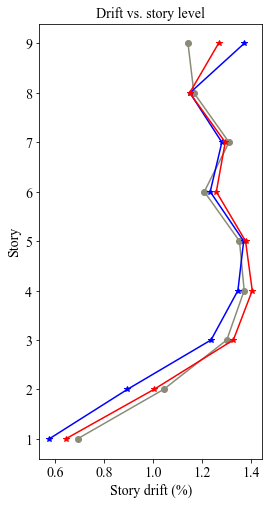

In [25]:
file_name = 'ConstructionDrift.csv'
FONTSIZE = 14
FIGSIZE = (4, 8)

drift_reference = extract_story_drift(building_IDs, file_name, 0.6)
drift_sensitivity01 = extract_story_drift(building_IDs, file_name, 0.8)
drift_sensitivity02 = extract_story_drift(building_IDs, file_name, 1.0)

fig = plt.figure(figsize = FIGSIZE)
story_level = list(range(1, total_story+1))
for each in range(0, len(building_IDs)):
    plt.plot(drift_reference[each], story_level, marker='o', color=(139/255, 139/255, 120/255))
    plt.plot(drift_sensitivity01[each], story_level, marker='*', color='blue')
    plt.plot(drift_sensitivity02[each], story_level, marker='*', color='red')
plt.title('Drift vs. story level', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
plt.xlabel('Story drift (%)', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
plt.ylabel('Story', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
plt.xticks(fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
plt.yticks(story_level, fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
plt.show()

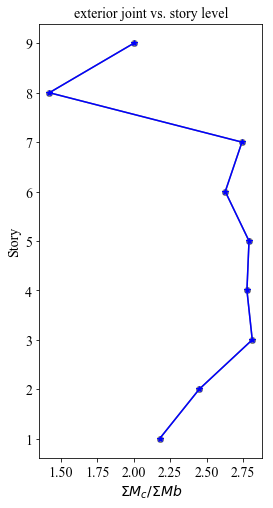

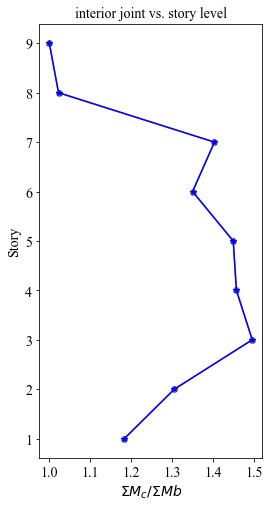

In [26]:
file_name = 'ConstructionColumnBeamRatio.csv'

SCWB_reference = extract_SCWB_ratio(building_IDs, file_name, True)
SCWB_sensitivity = extract_SCWB_ratio(building_IDs, file_name, False)
joint_names = ['exterior joint', 'interior joint']
for mn in joint_names:
    fig = plt.figure(figsize = FIGSIZE)
    for each in range(0, len(building_IDs)):
        plt.plot(SCWB_reference[mn][each], story_level, marker='o', color='grey')
        plt.plot(SCWB_sensitivity[mn][each], story_level, marker='*', color='blue')
    plt.title(mn+' vs. story level', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.xlabel('$\Sigma M_c/\Sigma Mb$', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.ylabel('Story', fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.xticks(fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.yticks(fontname='Times New Roman', fontsize=FONTSIZE, fontweight='light')
    plt.show()